Loaded image without alpha channel
Minimum size for connected components: 43 pixels
Found 8 unique colors


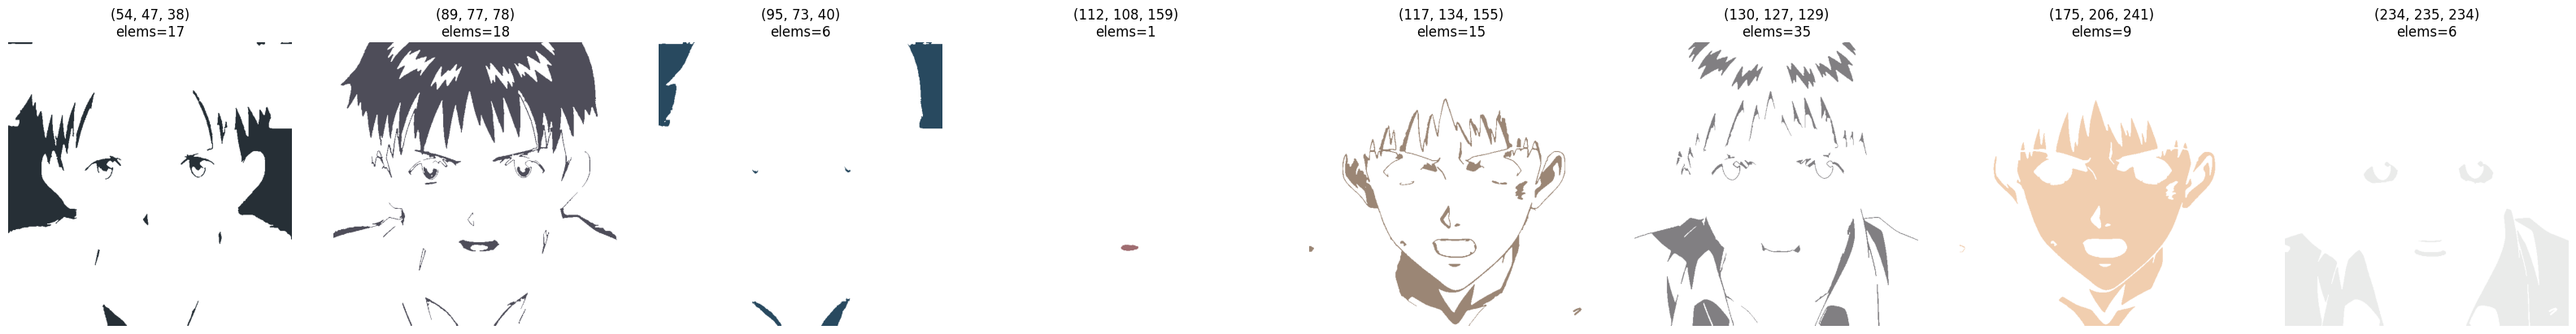

Element counts per color:
Color (54, 47, 38): 17 elements
Color (89, 77, 78): 18 elements
Color (95, 73, 40): 6 elements
Color (112, 108, 159): 1 elements
Color (117, 134, 155): 15 elements
Color (130, 127, 129): 35 elements
Color (175, 206, 241): 9 elements
Color (234, 235, 234): 6 elements
Total elements: 107


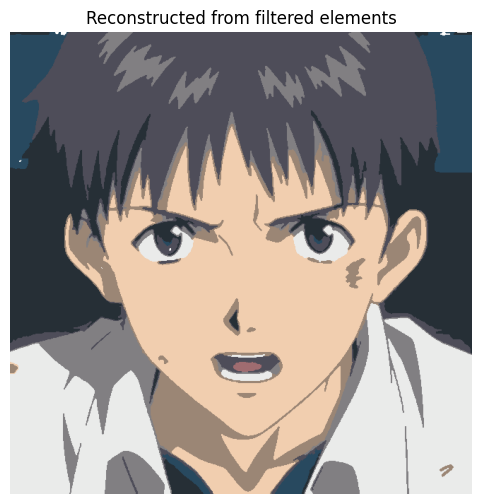

In [320]:
import cv2
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ----------------------------------------------------------------
IMAGE_PATH = "output.png"
MIN_SIZE_PERCENT = 1      # adjust as needed
BORDER_STRIP_SIZE = 1     # kernel size for stripping boundary pixels

# --- Load image (with alpha) and extract BGR + foreground mask ---------------
img = cv2.imread(IMAGE_PATH, cv2.IMREAD_UNCHANGED)
if img is None:
    raise FileNotFoundError(f"Could not load '{IMAGE_PATH}'")

# Separate channels
if img.shape[2] == 4:
    bgr   = img[:, :, :3]
    alpha = img[:, :, 3]
    mask_fg = (alpha == 255)
    print(f"Loaded image with alpha channel")
else:
    bgr   = img
    h, w  = bgr.shape[:2]
    mask_fg = np.ones((h, w), bool)  # everything is foreground
    print(f"Loaded image without alpha channel")
h, w = bgr.shape[:2]

# Compute minimum component size
MIN_SIZE = math.ceil((MIN_SIZE_PERCENT / 10000.0) * (h * w))
print(f"Minimum size for connected components: {MIN_SIZE} pixels")

# --- Build palette only from foreground pixels -------------------------------
# flatten only foreground pixels
fg_colors = bgr[mask_fg].reshape(-1, 3)
palette   = [tuple(c) for c in np.unique(fg_colors, axis=0).tolist()]
print(f"Found {len(palette)} unique colors")

# --- Prepare border‐stripping kernel ------------------------------------------
border_kernel = cv2.getStructuringElement(
    cv2.MORPH_CROSS,
    (BORDER_STRIP_SIZE, BORDER_STRIP_SIZE)
)

# --- Extract and filter connected components per color -----------------------
elements_by_color = {}
# make a uint8 mask for bitwise ops
mask_fg_u8 = (mask_fg.astype(np.uint8) * 255)
for color in palette:
    # 1) Binary mask for exactly this color, then restrict to foreground
    mask_color = cv2.inRange(bgr, np.array(color), np.array(color))
    mask_color = cv2.bitwise_and(mask_color, mask_fg_u8)
    
    # 2) Erode to strip boundary pixels touching non‐color
    mask_clean = cv2.erode(mask_color, border_kernel, iterations=1)
    
    # 3) Label connected components
    num_labels, labels = cv2.connectedComponents(mask_clean)
    comps = []
    for lbl in range(1, num_labels):
        comp_mask = (labels == lbl).astype(np.uint8) * 255
        # 4) Filter out tiny specks
        if cv2.countNonZero(comp_mask) > MIN_SIZE:
            comps.append(comp_mask)
    elements_by_color[color] = comps

# --- Visualize filtered elements per color and reconstruct image -------------
num_colors = len(palette)
fig, axes = plt.subplots(1, num_colors, figsize=(4 * num_colors, 4), constrained_layout=True)
if num_colors == 1:
    axes = [axes]

# start with blank white canvas (or any background color you prefer)
recon = np.full_like(bgr, 255)

for ax, color in zip(axes, palette):
    comps  = elements_by_color[color]
    canvas = np.full_like(bgr, 255)
    for comp in comps:
        mask_bool = comp.astype(bool)
        canvas[mask_bool] = color
        recon[mask_bool]  = color
    ax.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    ax.set_title(f"{color}\nelems={len(comps)}")
    ax.axis('off')

plt.show()

# Element counts
print("Element counts per color:")
total_elems = 0
for color, comps in elements_by_color.items():
    print(f"Color {color}: {len(comps)} elements")
    total_elems += len(comps)
print(f"Total elements: {total_elems}")

# Show reconstructed image
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(recon, cv2.COLOR_BGR2RGB))
plt.title("Reconstructed from filtered elements")
plt.axis('off')
plt.show()


Loaded image without alpha channel
Minimum size for connected components: 43 pixels
Found 8 unique colors
Found 42 contours and 35 filtered elements for color (np.uint8(130), np.uint8(127), np.uint8(129))
Found 7 contours and 6 filtered elements for color (np.uint8(234), np.uint8(235), np.uint8(234))
Found 17 contours and 9 filtered elements for color (np.uint8(175), np.uint8(206), np.uint8(241))
Found 21 contours and 17 filtered elements for color (np.uint8(54), np.uint8(47), np.uint8(38))
Found 10 contours and 6 filtered elements for color (np.uint8(95), np.uint8(73), np.uint8(40))
Found 25 contours and 15 filtered elements for color (np.uint8(117), np.uint8(134), np.uint8(155))
Found 1 contours and 1 filtered elements for color (np.uint8(112), np.uint8(108), np.uint8(159))
Found 33 contours and 18 filtered elements for color (np.uint8(89), np.uint8(77), np.uint8(78))

Reconstructing image from filtered elements...


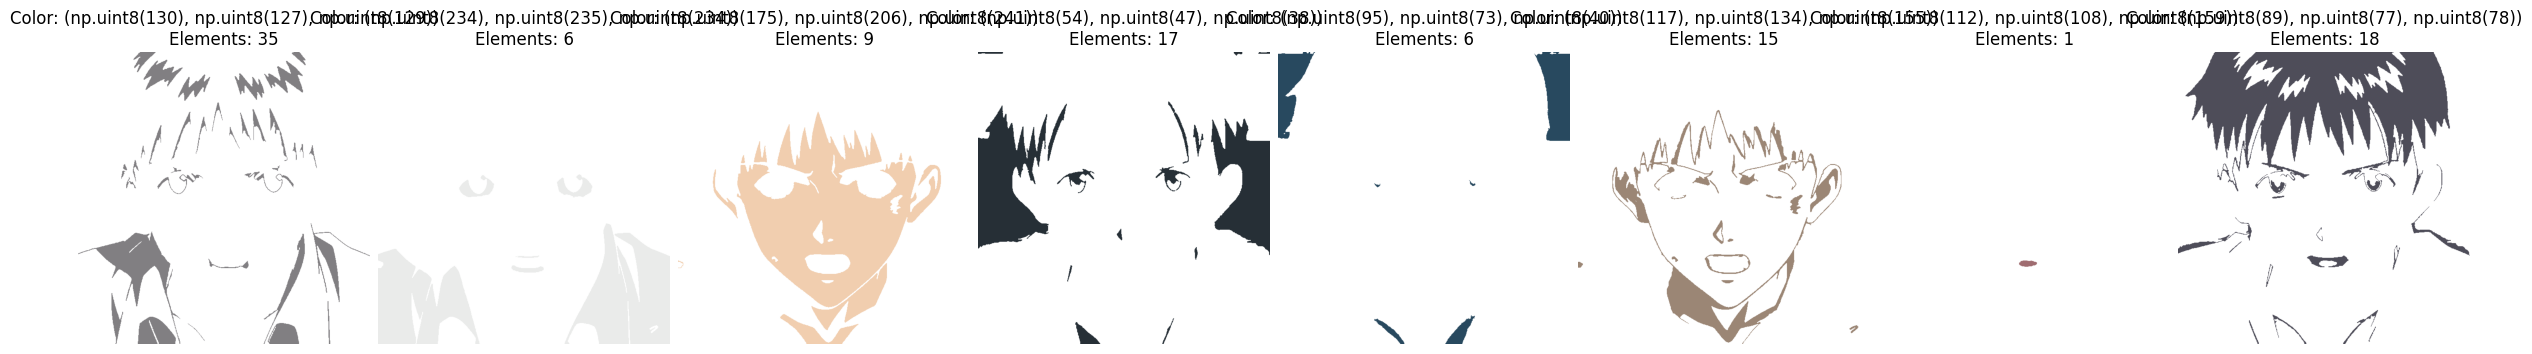


Element counts per color:
Color (np.uint8(130), np.uint8(127), np.uint8(129)): 35 elements
Color (np.uint8(234), np.uint8(235), np.uint8(234)): 6 elements
Color (np.uint8(175), np.uint8(206), np.uint8(241)): 9 elements
Color (np.uint8(54), np.uint8(47), np.uint8(38)): 17 elements
Color (np.uint8(95), np.uint8(73), np.uint8(40)): 6 elements
Color (np.uint8(117), np.uint8(134), np.uint8(155)): 15 elements
Color (np.uint8(112), np.uint8(108), np.uint8(159)): 1 elements
Color (np.uint8(89), np.uint8(77), np.uint8(78)): 18 elements
Total elements: 107


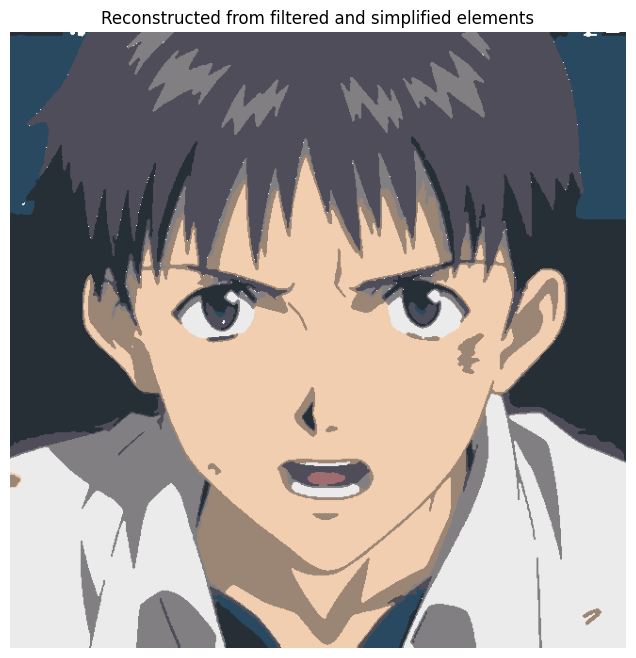

In [327]:
import cv2
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ----------------------------------------------------------------
IMAGE_PATH = "output.png"
MIN_SIZE_PERCENT = 1  # adjust as needed (e.g., 0.1% of image area)
BORDER_STRIP_SIZE = 1   # kernel size for eroding boundary pixels before contour finding
CONTOUR_SIMPLIFICATION_EPSILON = 0.0001 # Epsilon parameter for cv2.approxPolyDP (e.g., 1% of contour perimeter)

# --- Load image (with alpha) and extract BGR + foreground mask ---------------
img = cv2.imread(IMAGE_PATH, cv2.IMREAD_UNCHANGED)
if img is None:
    raise FileNotFoundError(f"Could not load '{IMAGE_PATH}'")

# Separate channels
if img.shape[2] == 4:
    bgr = img[:, :, :3]
    alpha = img[:, :, 3]
    mask_fg = (alpha == 255)
    print(f"Loaded image with alpha channel")
else:
    bgr = img
    h, w = bgr.shape[:2]
    mask_fg = np.ones((h, w), bool) # everything is foreground
    print(f"Loaded image without alpha channel")
h, w = bgr.shape[:2]

# Compute minimum component size
# MIN_SIZE_PERCENT is in percent of total pixels, convert to fraction
MIN_SIZE = math.ceil((MIN_SIZE_PERCENT / 10000.0) * (h * w))
print(f"Minimum size for connected components: {MIN_SIZE} pixels")

# --- Build palette only from foreground pixels -------------------------------
# flatten only foreground pixels
fg_colors = bgr[mask_fg].reshape(-1, 3)
# Use a set to get unique colors, then convert back to list of tuples
palette = list(set(tuple(c) for c in fg_colors))
print(f"Found {len(palette)} unique colors")

mode = cv2.RETR_TREE # Use RETR_EXTERNAL to get only outer contours
method = cv2.CHAIN_APPROX_NONE

# --- Prepare border‐stripping kernel ------------------------------------------
# Kernel used for erosion before contour finding
border_kernel = cv2.getStructuringElement(
    cv2.MORPH_CROSS,
    (BORDER_STRIP_SIZE, BORDER_STRIP_SIZE)
)

# --- Extract and filter elements per color using contours and simplification ---
elements_by_color = {}
# make a uint8 mask for bitwise ops
mask_fg_u8 = (mask_fg.astype(np.uint8) * 255)

for color in palette:

    # 1) Binary mask for exactly this color, then restrict to foreground
    mask_color = cv2.inRange(bgr, np.array(color), np.array(color))
    mask_color = cv2.bitwise_and(mask_color, mask_fg_u8)

    # 2) Erode to strip boundary pixels touching non-color (helps with cleaner contours)
    mask_clean = cv2.erode(mask_color, border_kernel, iterations=1)

    # 3) Find contours in the cleaned mask
    # cv2.findContours modifies the input mask, so use a copy if mask_clean is needed later
    contours, _ = cv2.findContours(mask_clean.copy(), mode, method)

    # 4) Create a blank canvas to draw filled, simplified contours
    canvas_filled_simplified = np.zeros_like(mask_color)

    # 5) Simplify contours and fill them
    simplified_contours = []
    for contour in contours:
        # Calculate contour perimeter
        perimeter = cv2.arcLength(contour, True)
        # Calculate epsilon for simplification (e.g., 1% of perimeter)
        epsilon = CONTOUR_SIMPLIFICATION_EPSILON * perimeter
        # Simplify the contour
        simplified_contour = cv2.approxPolyDP(contour, epsilon, True)
        simplified_contours.append(simplified_contour)

    # Fill the simplified contours on the canvas
    # Use -1 thickness to fill the contours
    cv2.drawContours(canvas_filled_simplified, simplified_contours, -1, 255, thickness=cv2.FILLED)

    # 6) Find connected components on the filled, simplified shapes
    num_labels, labels = cv2.connectedComponents(canvas_filled_simplified)

    # 7) Filter out small connected components by size
    comps = []
    for lbl in range(1, num_labels): # Start from 1 to skip background label
        comp_mask = (labels == lbl).astype(np.uint8) * 255
        # Get the area of the current component mask
        area = cv2.countNonZero(comp_mask)
        if area > MIN_SIZE:
            comps.append(comp_mask)

    elements_by_color[color] = comps
    print(f"Found {len(contours)} contours and {len(comps)} filtered elements for color {color}")


# --- Visualize filtered elements per color and reconstruct image -------------
num_colors = len(palette)
# Adjust figure size based on number of colors, add padding
fig_width = max(4, num_colors * 3) # Minimum width 4, then 3 per color
fig, axes = plt.subplots(1, num_colors, figsize=(fig_width, 4), constrained_layout=True)

# Ensure axes is an iterable even for a single color
if num_colors == 1:
    axes = [axes]

# start with blank white canvas (or any background color you prefer)
recon = np.full_like(bgr, 255)

print("\nReconstructing image from filtered elements...")
for ax, color in zip(axes, palette):
    comps  = elements_by_color[color]
    canvas = np.full_like(bgr, 255) # Canvas for displaying elements of one color

    if comps: # Check if there are any components for this color
    # Combine all component masks for this color into a single mask
        combined_mask = np.zeros_like(mask_color)
        for comp in comps:
            combined_mask = cv2.bitwise_or(combined_mask, comp)

         # Use the combined mask to color the canvas and the main reconstruction image
        mask_bool = combined_mask.astype(bool)
        canvas[mask_bool] = color
        recon[mask_bool]  = color

    ax.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Color: {color}\nElements: {len(comps)}")
    ax.axis('off')

plt.show()

# Element counts
print("\nElement counts per color:")
total_elems = 0
for color, comps in elements_by_color.items():
    print(f"Color {color}: {len(comps)} elements")
    total_elems += len(comps)
print(f"Total elements: {total_elems}")

# Show reconstructed image
plt.figure(figsize=(8,8)) # Increased figure size for better viewing
plt.imshow(cv2.cvtColor(recon, cv2.COLOR_BGR2RGB))
plt.title("Reconstructed from filtered and simplified elements")
plt.axis('off')
plt.show()

ID → parent, depth, area, perimeter:
 89 →   -, d=0, a=102046, p=5720
 41 →   -, d=0, a=93060, p=3450
 37 →   -, d=0, a=36088, p=1817
 74 →   -, d=0, a=30296, p=4234
 38 →   -, d=0, a=29182, p=1473
 55 →   -, d=0, a=29012, p=1727
 56 →   -, d=0, a=23066, p=1191
 27 →   -, d=0, a=11186, p=1303
 68 →   -, d=0, a=10654, p=583
 67 →   -, d=0, a=7946, p=579
 73 →   -, d=0, a=4660, p=2716
 32 →   -, d=0, a=3602, p=372
 49 →   -, d=0, a=3386, p=456
 26 →   -, d=0, a=2624, p=974
 33 →   -, d=0, a=2484, p=204
 28 →   -, d=0, a=2276, p=660
 35 →   -, d=0, a=1666, p=295
 71 →   -, d=0, a=1530, p=224
 36 →   -, d=0, a=1412, p=285
 66 →   -, d=0, a=1166, p=174
 96 →   -, d=0, a=1142, p=465
 97 →   -, d=0, a=1062, p=580
 59 →   -, d=0, a=988, p=337
 30 →   -, d=0, a=963, p=284
 60 →   -, d=0, a=942, p=385
  0 →   -, d=0, a=802, p=206
 72 →   -, d=0, a=746, p=192
  7 →   -, d=0, a=590, p=338
 94 →   -, d=0, a=434, p=193
 23 →   -, d=0, a=421, p=499
 91 →   -, d=0, a=421, p=242
  8 →   -, d=0, a=416, 

C:\Users\adamk\AppData\Local\Temp\ipykernel_16952\91000130.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


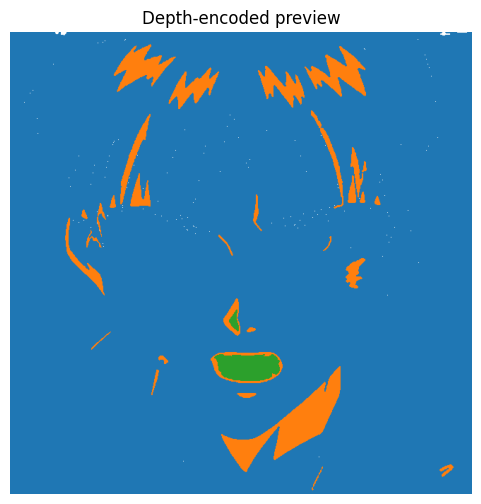

In [322]:
# --- Convert component masks into element dicts with contours ----------------
elements = []  # List of dicts: id, colour, contour, area, perimeter, centroid, parent, children, depth
for color, comps in elements_by_color.items():
    for comp in comps:
        cnts, _ = cv2.findContours(comp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if not cnts:
            continue
        cnt = cnts[0]
        area = cv2.contourArea(cnt)
        peri = cv2.arcLength(cnt, True)
        M    = cv2.moments(cnt)
        centroid = np.array([M['m10']/max(M['m00'],1e-6), M['m01']/max(M['m00'],1e-6)])
        eid = len(elements)
        elements.append({
            'id': eid,
            'colour': color,
            'contour': cnt,
            'area': area,
            'perimeter': peri,
            'centroid': centroid,
            'parent': None,
            'children': [],
            'depth': None,
        })

if not elements:
    raise RuntimeError("No elements extracted; check palette or MIN_SIZE.")

# --- Precompute bounding boxes for fast containment tests --------------------
for e in elements:
    e['bbox'] = cv2.boundingRect(e['contour'])  # (x,y,w,h)

# --- Determine parent-child relationships by containment ---------------------
for inner in elements:
    xi, yi, wi, hi = inner['bbox']
    best_parent, best_diff = None, float('inf')
    for outer in elements:
        if outer['area'] <= inner['area']:
            continue
        xo, yo, wo, ho = outer['bbox']
        if xo > xi or yo > yi or xo+wo < xi+wi or yo+ho < yi+hi:
            continue  # bounding box containment fail
        if cv2.pointPolygonTest(outer['contour'], tuple(inner['centroid']), False) < 0:
            continue  # centroid not inside
        diff = outer['area'] - inner['area']
        if diff < best_diff:
            best_diff, best_parent = diff, outer
    if best_parent:
        inner['parent'] = best_parent['id']
        best_parent['children'].append(inner['id'])

# --- Recursively assign depth (root depth=0) ---------------------------------
def set_depth(e, d):
    e['depth'] = d
    for cid in e['children']:
        set_depth(elements[cid], d+1)

for e in elements:
    if e['parent'] is None:
        set_depth(e, 0)

# --- Summary of layering -----------------------------------------------------
layered = sorted(elements, key=lambda e: (e['depth'], -e['area']))
print("ID → parent, depth, area, perimeter:")
for e in layered:
    print(f"{e['id']:>3} → {e['parent'] or '-':>3}, d={e['depth']}, a={e['area']:.0f}, p={e['perimeter']:.0f}")

# --- Visual check: color-coded by depth --------------------------------------
cmap = plt.cm.get_cmap('tab10')
depth_canvas = np.full((h,w,3), 255, np.uint8)
for e in layered:
    col_idx = e['depth'] % 10
    fake = tuple(int(c*255) for c in cmap(col_idx)[:3][::-1])
    cv2.drawContours(depth_canvas, [e['contour']], -1, fake, cv2.FILLED)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(depth_canvas, cv2.COLOR_BGR2RGB))
plt.title('Depth‑encoded preview')
plt.axis('off')
plt.show()

In [323]:
def make_checkerboard(H, W, block=20, a=(230,230,230), b=(200,200,200)):
    yy, xx = np.indices((H,W))
    patt = ((yy//block)+(xx//block))%2
    board = np.empty((H,W,3), np.uint8)
    board[patt==0] = a
    board[patt==1] = b
    return board

# Generate canvases per depth
depths = sorted({e['depth'] for e in elements})
canvases = []
for d in depths:
    cb = make_checkerboard(h, w)
    for e in elements:
        if e['depth']==d:
            cv2.drawContours(cb, [e['contour']], -1, e['colour'], cv2.FILLED)
    canvases.append((d, cb))

# Display in grid
cols, rows = 3, math.ceil(len(canvases)/3)
plt.figure(figsize=(cols*4, rows*4))
for i,(d,cb) in enumerate(canvases,1):
    plt.subplot(rows,cols,i)
    plt.imshow(cv2.cvtColor(cb, cv2.COLOR_BGR2RGB))
    plt.title(f'Depth {d}')
    plt.axis('off')
# fill empty slots
for j in range(i+1, rows*cols+1):
    plt.subplot(rows,cols,j); plt.axis('off')
plt.tight_layout(); plt.show()

# Final reconstruction
final = make_checkerboard(h, w)
for d in depths:
    for e in elements:
        if e['depth']==d:
            cv2.drawContours(final, [e['contour']], -1, e['colour'], cv2.FILLED)
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
plt.title('Depth‑stacked reconstruction')
plt.axis('off')
plt.show()

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'drawContours'
> Overload resolution failed:
>  - Scalar value for argument 'color' is not numeric
>  - Scalar value for argument 'color' is not numeric


In [277]:
# ──────────────────────────────────────────────────────────────────────────────
# Helpers
# ──────────────────────────────────────────────────────────────────────────────
def contour_to_svg_path(cnt):
    pts = cnt.reshape(-1, 2)
    if len(pts) == 0:
        return ""
    return (
        f"M {pts[0][0]} {pts[0][1]} "
        + " ".join(f"L {x} {y}" for x, y in pts[1:])
        + " Z"
    )

def bgr_to_hex(bgr):
    r, g, b = bgr[2], bgr[1], bgr[0]
    return f"#{r:02x}{g:02x}{b:02x}"

# ──────────────────────────────────────────────────────────────────────────────
# Prepare output
# ──────────────────────────────────────────────────────────────────────────────
output_folder = "exported_svgs"
os.makedirs(output_folder, exist_ok=True)
output_file = os.path.join(output_folder, "all_elements_depth_sorted.svg")


# ──────────────────────────────────────────────────────────────────────────────
# Build combined SVG content, sorting by depth ascending
# ──────────────────────────────────────────────────────────────────────────────
svg_header = f'''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg xmlns="http://www.w3.org/2000/svg"
     width="{w}" height="{h}"
     viewBox="0 0 {w} {h}">
'''

# sort elements so depth=0 drawn first, then depth=1, etc.
sorted_elems = sorted(elements, key=lambda e: e["depth"])

svg_groups = []
for elem in sorted_elems:
    cnt   = elem["contour"]
    col   = elem["colour"]
    eid   = elem["id"]
    depth = elem.get("depth", 0)
    area  = elem.get("area", 0.0)

    d = contour_to_svg_path(cnt)
    if not d:
        continue

    x, y, w, h = cv2.boundingRect(cnt)
    title = f"Element {eid} (depth {depth}, color {col})"
    desc  = f"bbox: x={x},y={y},w={w},h={h}; area={area:.1f}"
    fill_hex = bgr_to_hex(col)

    # include a data‑depth attribute for clarity
    group = f'''  <g id="elem_{eid}" data-depth="{depth}">
    <title>{title}</title>
    <desc>{desc}</desc>
    <path d="{d}" fill="{fill_hex}" stroke="none"/>
  </g>'''
    svg_groups.append(group)

svg_footer = "\n</svg>\n"

# ──────────────────────────────────────────────────────────────────────────────
# Write single SVG
# ──────────────────────────────────────────────────────────────────────────────
with open(output_file, "w", encoding="utf-8") as f:
    f.write(svg_header)
    f.write("\n".join(svg_groups))
    f.write(svg_footer)

print(f"Exported combined SVG with {len(svg_groups)} elements (depth‑sorted) to '{output_file}'")


Exported combined SVG with 32 elements (depth‑sorted) to 'exported_svgs\all_elements_depth_sorted.svg'
